In [1]:
#参考 https://www.jianshu.com/p/a8d75f06194b
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
#一、加载数据
train = pd.read_csv(r'../dataset/tatanic/train.csv')
test = pd.read_csv(r'../dataset/tatanic/test.csv')
#all_data = pd.concat([train, test], ignore_index=True)

In [20]:
# 魔法指令 删除变量
%xdel all_data

In [32]:
#二、 查看数据、数据类型
pd.set_option('display.max_columns', None) # 展示所有列
# head 默认展示5行
print(train.head())
#数据描述，以列为单位，统计数量:平均值，最大值等
print(train.describe())
# 数据信息，类似表描述，占用空间大小
#数据行数是891，而 Age只有714, 列有的信息是空的
print(train.info())
# 统计Age值每个值数量
print(train["Age"].value_counts())
# 数据描述---
#数据维度
print(train.shape)
#数据类型
##print(train.dtypes.sort_values())
#相同数据
print(train.select_dtypes(include='int64').head())
#统计缺失的值
train.isnull().sum()[lambda x: x>0]

   PassengerId  Survived  Pclass(客舱等级，较为重要)  \
0            1         0                  3   
1            2         1                  1   
2            3         1                  3   
3            4         1                  1   
4            5         0                  3   

                                                Name     Sex   Age  \
0                            Braund, Mr. Owen Harris    male  22.0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2                             Heikkinen, Miss. Laina  female  26.0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4                           Allen, Mr. William Henry    male  35.0   

   SibSp(堂兄弟妹个数)  Parch(父母与小孩个数)       Ticket(票编号)  Fare(票价) Cabin(客舱编号)  \
0              1               0         A/5 21171    7.2500         NaN   
1              1               0          PC 17599   71.2833         C85   
2              0               0  STON/O2. 3101282    7.9250        

In [5]:
#-----------三、数据清洗-------
drop_features=['PassengerId']#,'Survived'
#3.1 删除无用的列  (axis=1 表示列 0表示行)
train_after_drop=train.drop(drop_features,axis=1)
train_after_drop=train_after_drop.rename(columns={u'Pclass(客舱等级，较为重要)':'Pclass'})
train_after_drop=train_after_drop.rename(columns={u'SibSp(堂兄弟妹个数)':'SibSp'})
train_after_drop=train_after_drop.rename(columns={u'Parch(父母与小孩个数)':'Parch'})
train_after_drop=train_after_drop.rename(columns={u'Ticket(票编号)':'Ticket'})
train_after_drop=train_after_drop.rename(columns={u'Fare(票价)':'Fare'})
train_after_drop=train_after_drop.rename(columns={u'Cabin(客舱编号)':'Cabin'})
train_after_drop=train_after_drop.rename(columns={u'Embarked(上船的港口编号)':'Embarked'})

In [12]:
# age+name的称呼，分成几类
# 寻找隐藏特征- age分类
## 名称带Mr, Mrs,Miss
train_after_drop['Title'] = train_after_drop["Name"].apply(lambda name: name.split(',')[1].split('.')[0].strip())
# value_counts函数用于统计dataframe或series中不同数或字符串出现的次数
print(train_after_drop.Title.value_counts())
List=train_after_drop.Title.value_counts().index[4:].tolist()
mapping={}
for s in List:
    mapping[s]='Rare'
train_after_drop['Title']=train_after_drop['Title'].map(lambda x: mapping[x] if x in mapping else x)
# 处理缺失值：丢弃特征确实过多、不缺确实值
## 根据已有数据(Mr,Mrs,Miss)，补全缺失数据。
grouped=train_after_drop.groupby(['Title'])
median=grouped.Age.median()
print(median)
def newage (cols):
    age=cols[0]
    title=cols[1]
    if pd.isnull(age):
        return median[title]
    return age
train_after_drop.Age=train_after_drop[['Age','Title']].apply(newage,axis=1)

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Mme               1
Capt              1
Lady              1
the Countess      1
Don               1
Ms                1
Sir               1
Jonkheer          1
Name: Title, dtype: int64
Title
Master     3.5
Miss      21.0
Mr        30.0
Mrs       35.0
Rare      44.5
Name: Age, dtype: float64


In [6]:
#转换行吧
#loc根据属性定位，包含条件时，选择满足条件的Series
train_after_drop.loc[train_after_drop['Sex'] == 'male', 'Sex'] = 0
train_after_drop.loc[train_after_drop['Sex'] == 'female', 'Sex'] = 1
train_after_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [7]:
#Embarked(上船的港口编号)
train_after_drop['Embarked'] = train_after_drop['Embarked'].fillna('S')
train_after_drop.loc[train_after_drop['Embarked'] == 'S', 'Embarked'] = 0
train_after_drop.loc[train_after_drop['Embarked'] == 'C', 'Embarked'] = 1
train_after_drop.loc[train_after_drop['Embarked'] == 'Q', 'Embarked'] = 2
#titanic['has_Cabin'].loc[~titanic.Cabin.isnull()]=1
#titanic['has_Cabin'].loc[titanic.Cabin.isnull()]=0


In [8]:
#仓位号-舱位号缺失的乘客的幸存率远远低于有舱位号的乘客，把Cabin的缺失值划为单独的一类。
train_after_drop[u'Cabin'] = train_after_drop[u'Cabin'].fillna('U')
train_after_drop[:10]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U,0
5,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,U,2
6,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.8625,E46,0
7,0,3,"Palsson, Master. Gosta Leonard",0,2.0,3,1,349909,21.0750,U,0
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.0,0,2,347742,11.1333,U,0
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.0,1,0,237736,30.0708,U,1


In [9]:
#Embarked(上船的港口编号)- 直接处理成最大(最大先验概率)
most_embarked = train_after_drop[u"Embarked"].value_counts().index[0]
train_after_drop[u"Embarked"]=train_after_drop[u"Embarked"].fillna(most_embarked)
train_after_drop.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U,0


In [13]:
#Fare(票价) 只有一个空值
train_after_drop["Fare"] = train_after_drop["Fare"].fillna(train_after_drop["Fare"].median())
train_after_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     891 non-null    object 
 10  Embarked  891 non-null    int64  
 11  Title     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# 数据清洗结束
# -------五、 特征工程

In [17]:
#合并SibSp+Parch=familySize 家庭人数
#train_after_drop=train_after_drop.rename(columns={u'familySize':'FamilySize'})
train_after_drop["FamilySize"]=train_after_drop["SibSp"]+train_after_drop["Parch"]
train_after_drop["NameLength"]=train_after_drop["Name"].apply(lambda x: len(x))
train_after_drop.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,NameLength,FamilySize
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,U,0,1,23,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,3,51,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,U,0,2,22,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,3,44,1
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,U,0,1,24,0


In [15]:
#名字越长 Title：在Name里提取的，类似Mr、Mrs、Dr表示性别职业
import re
import pandas as pd
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)

    if title_search:
        return title_search.group(1)
    return ''
titles = train_after_drop['Name'].apply(get_title)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 8, "Mlle": 9,
                 "Mme": 10, "Don": 11, "Lady": 12, "Countess": 13, "Jonkheer": 14, "Sir": 15, "Capt": 16, "Ms": 17
                 }
for k, v in title_mapping.items():
    titles[titles == k] = v
print(pd.value_counts(titles))
train_after_drop['Title'] = titles


1     517
2     182
3     125
4      40
5       7
6       6
8       2
7       2
9       2
16      1
10      1
11      1
12      1
13      1
14      1
15      1
17      1
Name: Name, dtype: int64


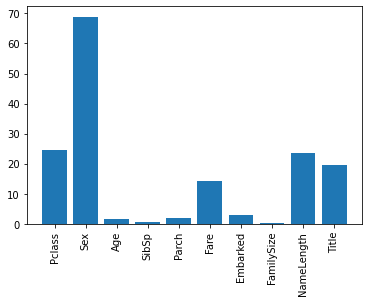

In [18]:
#-------5.1、特征选择

predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked",
"FamilySize", "NameLength", "Title"]
selector = SelectKBest(f_classif, k=5)# 方差分析，计算方差分析（ANOVA）的F值 (组间均方 / 组内均方)，选取前5个特征

selector.fit(train_after_drop[predictors], train['Survived'])
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


In [19]:
#---------六、选择模型------
#6.1 线性模型
from sklearn import metrics
# 训练选择特征
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# 导入线性回归
alg = LinearRegression()
# k-交叉验证。将样本分为3份进行交叉验证
#执行index  = kFold.split(X=X)：index是一个生成器，每个元素是一个元组，元组里面有两个元素，第一个是训练集的索引，第二个是验证集的索引
kf = KFold(train_after_drop.shape[0], n_splits=3, random_state=1)
predictions = []
for train_index, test_index in kf.split(train_after_drop[predictions]):
    # 用于训练的特征数据
    train_predictors = train_after_drop[predictors].iloc[train_index, :]
    # 特征数据的label(即是否获救)
    train_target = train['Survived'].iloc[train_index]  # train_target = titanic['Survived'][train_index]
    # 训练线性回归模型
    alg.fit(train_predictors, train_target)
    test_predictions = alg.predict(train_after_drop[predictors].iloc[test_index, :])
    predictions.append(test_predictions)
# 线性回归得到的结果是在[0,1]，转化为类别
# 按轴axis连接array组成一个新的array
predictions = np.concatenate(predictions, axis=0)# predictions = np.hstack(predictions)
predictions[predictions > .5] = 1
predictions[predictions <= .5] = 0
# predictions = np.where(predictions > .5, 1, 0)
# 线性模型准确率
accuracy = sum(predictions == train_after_drop['Survived']) / len(predictions)
print(accuracy)

0.7968574635241302


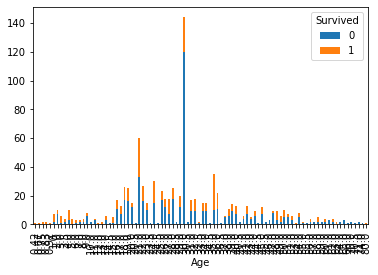

In [29]:
len_train=891
#特征对预测结果的相关度
pd.crosstab(train_after_drop.Age[:len_train],train.Survived).plot.bar(stacked=True)